Pobranie niezbędnych bibliotek

In [1]:
import pandas as pd
import string 
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

#library used to count the frequency of words
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
#nltk.download('wordnet') 
#nltk.download('omw-1.4')

Pobranie tekstów piosenek

In [2]:
df=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/Metallica_songs.csv', sep=';')
df.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
158,Remember Tomorrow,Iron Maiden,"Steve Harris,Paul Di’Anno",5:46,Maiden Heaven: A Tribute to Iron Maiden,Compilation,2.0,2008-07-16,https://www.metallica.com/songs/remember-tomor...,"Unchain the colors,Before my eyes,Yesterday’s ..."
12,Astronomy,Blue Öyster Cult,"Sandy Pearlman,Albert Bouchard,Joe Bouchard",6:37,Garage Inc.,Covers,8.0,1998-11-24,https://www.metallica.com/songs/astronomy.html,"Clock strikes twelve and moondrops burst,Out a..."
218,You Really Got Me,The Kinks,Ray Davies,2:15,See My Friends,Collaborative,5.0,2010-11-01,https://www.metallica.com/songs/you-really-got...,"Girl you really got me goin’,You got me so I d..."
192,The Train Kept-A-Rollin’,Tiny Bradshaw,"Tiny Bradshaw,Lois Mann,Howard Kay",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/the-train-kept...,"I caught a train met a dame,She was a hipster ..."
136,No Leaf Clover,Metallica,"James Hetfield,Lars Ulrich",5:43,S&M,Live,8.0,1999-11-23,https://www.metallica.com/songs/no-leaf-clover...,"And it feels right this time,On his crash cour..."


Przygotowanie niezbędnych funkcji

In [15]:
def clean_lyrics(df,column):
    #Funkcja usuwa didaskalia i przygotowuje tekst do dalszej obróbki 
    
    df['Lyrics'] = df['Lyrics'].str.lower()
    df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro"," ").str.replace("["," ").str.replace("]"," ")
    df['Lyrics'] = df['Lyrics'].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df['Lyrics'] = df['Lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+"," ").str.replace("efil ym fo flah"," ")
    df['Lyrics'] = df['Lyrics'].str.strip()

    return df

def lyrics_to_words(document):
    #Funkcja dzieli tekst na pojedyncze słowa i normalizuje tekst
  
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

In [16]:
df_cleaned = clean_lyrics(df,'Lyrics')
df = df[df['Lyrics'].notnull()]
df_cleaned.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words,frequency
27,The Day That Never Comes,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",7:55,Death Magnetic,Album,4.0,2008-09-12,https://www.metallica.com/songs/the-day-that-n...,born to push you around better just stay down ...,"[born, push, around, better, stay, pull, away,...",0
142,Welcome Home (Sanitarium),Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",6:28,Master of Puppets,Album,4.0,1986-03-03,https://www.metallica.com/songs/welcome-home-s...,welcome to where time stands still no one leav...,"[welcome, time, stand, still, one, leaf, moon,...",0
12,Better Than You,Metallica,"James Hetfield,Lars Ulrich",5:21,Reload,Album,5.0,1997-11-18,https://www.metallica.com/songs/better-than-yo...,i look at you then you me hungry and thirsty a...,"[look, hungry, thirsty, holding, lion, share, ...",0
13,Blackened,Metallica,"James Hetfield,Lars Ulrich,Jason Newsted",6:42,...And Justice for All,Album,1.0,1988-08-25,https://www.metallica.com/songs/blackened.html,blackened is the end winter it will send throw...,"[blackened, end, winter, send, throwing, see, ...",0
140,Wasting My Hate,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",3:57,Load,Album,10.0,1996-06-04,https://www.metallica.com/songs/wasting-my-hat...,good day how do and i send a smile to you don...,"[good, day, send, smile, waste, breath, hate, ...",0


Ze zbioru utworów usuwam piosenki nie będące autorstwa Metallici.

In [17]:
df_cleaned2 = df_cleaned[df_cleaned['Author_band'] == 'Metallica']
df_cleaned2.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/teksty.csv',index=False)
df_cleaned2.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words,frequency
7,(Anesthesia) - Pulling Teeth,Metallica,Cliff Burton,4:14,Kill 'Em All,Album,5.0,1983-07-25,https://www.metallica.com/songs/anesthesia-pul...,,[],0
74,Little Dog,Metallica,"Lou Reed,James Hetfield,Lars Ulrich,Kirk Hamme...",8:00,Lulu,Collaborative,8.0,2011-10-31,https://www.metallica.com/songs/little-dog.html,little dog who can t get in moaning at the bed...,"[little, dog, get, moaning, bed, side, limb, c...",0
28,Dead Kennedy Rolls,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/dead-kennedy-r...,hey man do your guesses ever know hey man won'...,"[hey, man, guess, ever, know, kick, luck, watc...",0
12,Better Than You,Metallica,"James Hetfield,Lars Ulrich",5:21,Reload,Album,5.0,1997-11-18,https://www.metallica.com/songs/better-than-yo...,i look at you then you me hungry and thirsty a...,"[look, hungry, thirsty, holding, lion, share, ...",0
8,"Atlas, Rise!",Metallica,"James Hetfield,Lars Ulrich",6:28,Hardwired... to Self-Destruct,Album,2.0,2016-11-18,https://www.metallica.com/songs/atlas-rise.html,bitterness and burden curses rest on thee soli...,"[bitterness, burden, curse, rest, thee, solita...",0


In [19]:
def unique(list1):
   #pusta lista
     unique_list = []
   #przejdź przez listę
     for x in list1:
         #sprawdź czy występuje w unique_list
         if x not in unique_list:
              unique_list.append(x)
     return unique_list

In [20]:
#Przechowuje unikalne słowa wszystkich piosenek w nowej kolumnie 'words'

#lista do przechowywania słów
words = []

#iteracja przez wszystkie teksty i dzieli unikalne słowa dodając je do listy słów
df_cleaned2 = df_cleaned2.reset_index(drop=True)
for word in df_cleaned2['Lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
    
#dodaj zebrane słowa do kolumny 'words'
df_cleaned2['words'] = words
df_cleaned2.head()

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words,frequency
0,2 x 4,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",5:28,Load,Album,2.0,1996-06-04,https://www.metallica.com/songs/2x4.html,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc...",0
1,72 Seasons,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",7:39,72 Seasons,Album,1.0,2023-04-14,https://www.metallica.com/songs/72-seasons.html,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h...",0
2,Ain’t My Bitch,Metallica,"James Hetfield,Lars Ulrich",5:04,Load,Album,1.0,1996-06-04,https://www.metallica.com/songs/aint-my-bitch....,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,...",0
3,All Nightmare Long,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",8:01,Death Magnetic,Album,5.0,2008-09-12,https://www.metallica.com/songs/all-nightmare-...,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif...",0
4,All Within My Hands,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",8:48,St. Anger,Album,11.0,2003-06-05,https://www.metallica.com/songs/all-within-my-...,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf...",0


In [21]:
#dodaję nową kolumnę, w której zawarta będzie informacja o liczbie wystąpień unikalnych słów
df_cleaned2['frequency'] = 0
df_cleaned2['frequency'] = df_cleaned2['frequency'].astype(int)
df = df_cleaned2

#puste listy
set_words = []
set_frequency = []

#tworzy listę słów z kolumny Lyrics i liczy liczbę wystąpień
for i in df.index:
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_frequency.append(df['frequency'].iloc[i])

#tworzy nowy data frame, który zawiera unikalne słowa i liczbę ich wystąpień
words_df = pd.DataFrame({'words':set_words,'frequency':set_frequency})

In [22]:
df.head()

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words,frequency
0,2 x 4,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",5:28,Load,Album,2.0,1996-06-04,https://www.metallica.com/songs/2x4.html,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc...",0
1,72 Seasons,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",7:39,72 Seasons,Album,1.0,2023-04-14,https://www.metallica.com/songs/72-seasons.html,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h...",0
2,Ain’t My Bitch,Metallica,"James Hetfield,Lars Ulrich",5:04,Load,Album,1.0,1996-06-04,https://www.metallica.com/songs/aint-my-bitch....,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,...",0
3,All Nightmare Long,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",8:01,Death Magnetic,Album,5.0,2008-09-12,https://www.metallica.com/songs/all-nightmare-...,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif...",0
4,All Within My Hands,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",8:48,St. Anger,Album,11.0,2003-06-05,https://www.metallica.com/songs/all-within-my-...,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf...",0


In [24]:
#Zbiór własnych stop_words wg potrzeb
stop_words = ['45','verse','im','get','1000','58','60','80','youre','youve',
               'guitar','solo','instrumental','intro','pre',"3","yo","yeah"]

#Policzy częstotliwość każdego ze słów z wyjątkiem tych z listy 'stop_words'          
cv = CountVectorizer(stop_words=stop_words)

#Stworzy dataframe o nazwie "data_cv" do przechowywania informacji o tym ile razy zostało użyte dane słowo
text_cv = cv.fit_transform(words_df['words'].iloc[:])
data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names_out())
data_cv['frequency'] = words_df['frequency']

vect_words = data_cv.groupby('frequency').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')

#Zapisze dane do plik
vect_words.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv',index=False)



In [25]:
words=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv', sep=',')


In [26]:
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   words   2828 non-null   object
 1   0       2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [27]:
words.rename(columns={'0': 'frequency'}, inplace=True)

# Sprawdzenie zmian
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   words      2828 non-null   object
 1   frequency  2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [28]:
words_sorted = words.sort_values(by='frequency', ascending=False)
words_sorted.head(20)

,words,frequency
1395,life,57
1628,never,54
2457,take,53
2098,see,52
123,away,48
2538,time,48
429,come,47
1683,one,46
858,feel,45
2061,say,40


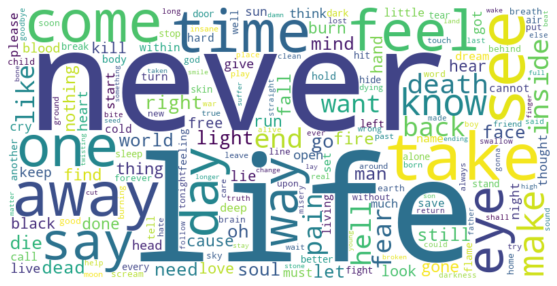

In [30]:
#tworzy słownik z df
word_freq = dict(zip(words_sorted['words'], words_sorted['frequency']))

font_path = 'C:/Windows/Fonts/arial.ttf'

# Generowanie chmury słów
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Wyświetlenie chmury słów
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
def words_stats(df,main_df):
    unique_words = []
    total_words = []
    total_news = []
    years = []
    for value in df.columns[1:]:
         unique_words.append(np.count_nonzero(df[value]))
         total_words.append(sum(df[value]))
         years.append(str(value))
         total_news.append(main_df['frequency'][main_df['frequency']==value].count())
    
    data = pd.DataFrame({'unique words':unique_words,'total words':total_words,'total songs':total_news})
    data['words per songs'] = round(data['total words'] / data['total songs'],0)
    data['words per songs'] = data['words per songs'].astype('int')
    return data


In [32]:
words_stats(vect_words,df)

,unique words,total words,total songs,words per songs
0,2828,8646,147,59
